In [1]:
import sys,os,glob,copy
sys.path.append('../')
import numpy as np
from numpy.linalg import norm
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.interpolate import LinearNDInterpolator,interp2d
import matplotlib as mpl
from matplotlib.colors import LogNorm
from IPython.display import display, Markdown
import pylhe
import pyslha
import ROOT

ROOT.gSystem.Load(os.path.abspath("/home/lessa/MonoXSMS/MG5/Delphes/libDelphes.so"))

ROOT.gInterpreter.Declare('#include "classes/SortableObject.h"')
ROOT.gInterpreter.Declare('#include "classes/DelphesClasses.h"')
ROOT.gInterpreter.Declare('#include "external/ExRootAnalysis/ExRootTreeReader.h"')

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution


#Define plotting style:
sns.set() #Set style
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.cm.get_cmap('RdYlBu')

Welcome to JupyROOT 6.24/06


In [2]:
parameters = pyslha.readSLHAFile('./DMSimp_monojet_Vector/Cards/param_card.dat')
mMed = parameters.blocks['MASS'][55]
mDM = parameters.blocks['MASS'][52]
gVq = parameters.blocks['DMINPUTS'][4] # Mediator-quark vector coupling
gAq = parameters.blocks['DMINPUTS'][10] # Mediator-quark axial coupling
gVx = parameters.blocks['DMINPUTS'][2] # Mediator-DM vector coupling
gAx = parameters.blocks['DMINPUTS'][3] # Mediator-DM axial coupling

In [3]:
inputFiles = {'point1' : './test.root'}
xsecsPB = {'point1' : 1.553e+02}

In [4]:
# Cuts 
## jets
pTmin = 250.
etamax = 2.4
nMin = 1
## MET
minMET = 250.
## Electrons
pTmin_el = 10.
etamax_el = 2.5
nMax_el = 0
## Muons
pTmin_mu = 10.
etamax_mu = 2.4
nMax_mu = 0


In [23]:
pTj1 = []
weights = []
for label,inputFile in inputFiles.items():

    f = ROOT.TFile(inputFile,'read')
    tree = f.Get("Delphes")
    nevts = tree.GetEntries()
    
    for ievt in range(nevts):    
        tree.GetEntry(ievt)        

#        particles = tree.Particle
        jets = tree.Jet
        weight = xsecsPB[label]/nevts

        missingET = tree.MissingET.At(0)
        electrons = tree.Electron
        muons = tree.Electron

        
        
        # Cut on MET
#         if missingET.MET < minMET:
#             continue
            
        # Filter electrons:
        electronList = []
        for iel in range(electrons.GetEntries()):
            electron = electrons.At(iel)
            if electron.PT < pTmin_el:
                continue
            if abs(electron.Eta) > etamax_el:
                continue
            electronList.append(electron)
        
        # Veto electrons
        if len(electronList) > nMax_el:
            continue

        # Filter muons:
        muonList = []
        for imu in range(muons.GetEntries()):
            muon = muon.At(imu)
            if muon.PT < pTmin_mu:
                continue
            if abs(muon.Eta) > etamax_mu:
                continue
            muonList.append(muon)
        
        # Veto muons
#         if len(muonList) > nMax_mu:
#             continue

        # Filter jets
        jetList = []
        for ijet in range(jets.GetEntries()):
            jet = jets.At(ijet)
            if jet.PT < pTmin:
                continue
            if abs(jet.Eta) > etamax:
                continue
            jetList.append(jet)
            
        # Veto zero jet events
        if len(jetList) < nMin:
            continue
        jetList = sorted(jetList, key = lambda j: j.PT, reverse=True)
        
        pTj1.append(jetList[0].PT)
        weights.append(weight)

weights = np.array(weights)
pTj1 = np.array(pTj1)

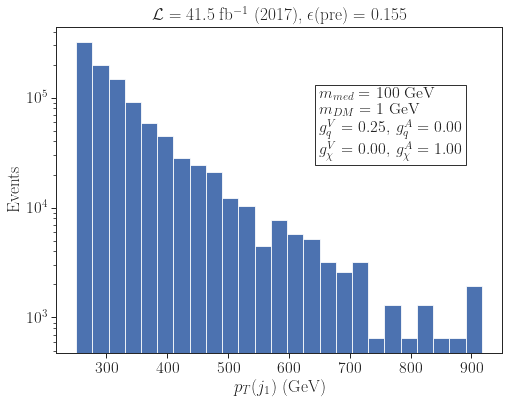

In [65]:
lum2017 = 41.5 #fb^-1
fig = plt.figure(figsize=(8,6))
plt.hist(pTj1,bins=25,weights=weights*1e3*lum2017)
plt.title(r'$\mathcal{L} = %1.1f$ fb$^{-1}$ (2017), $\epsilon$(pre) = %1.3f' %(lum2017,len(pTj1)/nevts))
plt.xlabel(r'$p_{T}(j_{1})$ (GeV)')
plt.ylabel('Events')
plt.yscale('log')
textstr = '\n'.join((
    r'$m_{med} =$ %1.0f GeV' %mMed, 
    r'$m_{DM} =$ %1.0f GeV' %mDM,
    r'$g_{q}^{V}=$ %1.2f, $g_{q}^{A}=$ %1.2f' % (gVq, gAq),
    r'$g_{\chi}^{V}=$ %1.2f, $g_{\chi}^{A}=$ %1.2f' % (gVx, gAx)))
plt.text(650,3e4,textstr,fontsize=16,bbox=dict(facecolor='none', edgecolor='black'))
plt.show()